In [8]:
%env GEOMSTATS_BACKEND=pytorch

env: GEOMSTATS_BACKEND=pytorch


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append("..")  

import os
import numpy as np
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


from scipy.spatial.transform import Rotation
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

from utils.plotting import plot_so3
from foldflow.utils.so3_helpers import norm_SO3, expmap, exp, hat
from utils.so3_cfm import SO3SFM
from utils.optimal_transport import so3_wasserstein as wasserstein
from so3_experiments.models.models import PMLP

from torch.utils.data import DataLoader
from data.datasets import SpecialOrthogonalGroup

from geomstats._backend import _backend_config as _config
_config.DEFAULT_DTYPE = torch.cuda.FloatTensor 

savedir = "models/so3_synthetic"
os.makedirs(savedir, exist_ok=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "5"


cuda:0
size of toy dataset:  50000


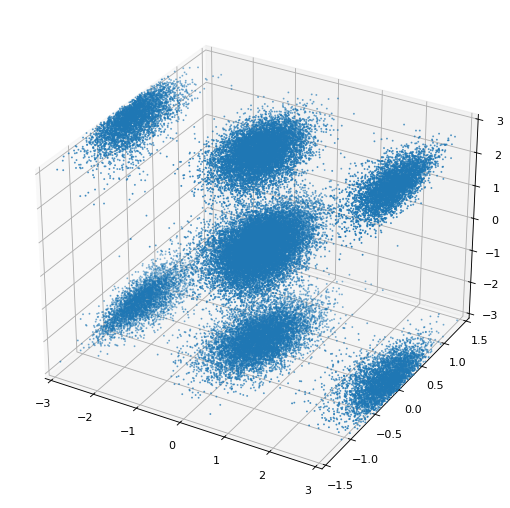

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load toy dataset
data = np.load('data/orthogonal_group.npy')
print('size of toy dataset: ', len(data))

fig = plot_so3(data)
plt.savefig('figs/so3_synthetic_data.png', dpi=300)
plt.show()

### Dataloader

In [12]:
# load data
trainset = SpecialOrthogonalGroup(split="train")
trainloader = DataLoader(
    trainset, batch_size=1024, shuffle=True, num_workers=0
)

valset = SpecialOrthogonalGroup(split="valid")
valloader = DataLoader(
    valset, batch_size=256, shuffle=False, num_workers=0
)

testset = SpecialOrthogonalGroup(split="test")
testloader = DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=0
)

### Stochastic OT CFM

This is a stochastic SO(3) OTCFM. 
The flow is calculated at a sample drawn an approximation of the conditional probability path: 

 $\hat{\rho}_t(\tilde{r}_t|r_0, r_1) = \mathcal{IG}_\mathrm{SO(3)}\Big(\tilde{r}_t; \exp_{r_0}(t \log_{r_0}(r_1)), \gamma^2(t) t(1-t)\Big)$

In [13]:
so3_group = SpecialOrthogonal(n=3, point_type="matrix")
FM = SO3SFM(manifold=so3_group) 

### Loss Functions

The final loss corresponds to equation (8) in the paper:

$$ \mathcal{L}_{\mathrm{sfm}-\mathrm{SO(3)}}(\theta) = \mathbb{E}_{t\sim \mathcal{U}(0,1), \bar{\pi}(r_0, r_1), \rho_t(\tilde{r}_t | r_0, r_1)} \left \|v_\theta(t, \tilde{r}_t) - \log_{\tilde{r}_t}(r_0)/t \right\|_{\mathrm{SO(3)}}^2.$$

In [14]:
def cfm_loss(v1, v2, x):
    res = v1 - v2
    norm = norm_SO3(x, res)
    loss = torch.mean(norm, dim=-1)
    return loss

### SDE Inference

In [15]:
def skew_matrix_to_axis_angle(skew_matrices: torch.Tensor) -> torch.Tensor:
    """
    Extract a rotation vector from the so(3) skew matrix basis.

    Args:
        skew_matrices (torch.Tensor): Skew matrices.

    Returns:
        torch.Tensor: Rotation vectors corresponding to skew matrices.
    """
    vectors = torch.zeros_like(skew_matrices[..., 0])
    vectors[..., 0] = skew_matrices[..., 2, 1]
    vectors[..., 1] = skew_matrices[..., 0, 2]
    vectors[..., 2] = skew_matrices[..., 1, 0]
    
    rot_angle_1 = torch.norm(vectors, dim=-1, keepdim=True)
    rot_axis_1 = vectors / rot_angle_1
    rot_axis_1 = rot_axis_1.unsqueeze(-2)
    rot_angle_1 = rot_angle_1
    return rot_axis_1, rot_angle_1 % (2 * np.pi)

Training: 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


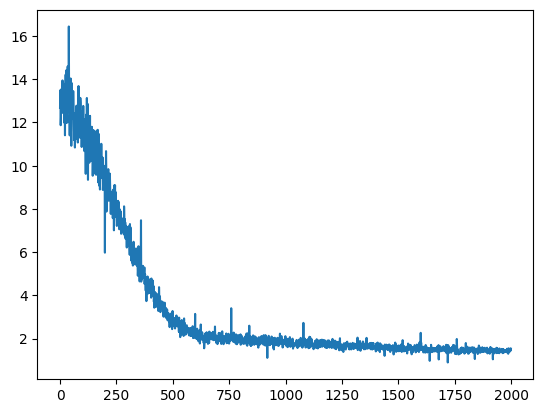

In [16]:
import utils.rotation_conversions as rc
from utils.bfn_base import bfnBase
from tqdm import trange
from FoldFlow.so3.so3_helpers import geodesic_distance

def rotmat_to_axis_angle(rotmats):
    rotvecs_1 = rc.matrix_to_axis_angle(rotmats, fast=True)
    rot_angle_1 = torch.norm(rotvecs_1, dim=-1, keepdim=True)
    rot_axis_1 = rotvecs_1 / rot_angle_1
    return rot_axis_1, rot_angle_1 % (2 * torch.pi)

def net_pred(net, x_t, t, acc_axis, acc_angle, return_rotmat=False):
    vt = net(torch.cat([
                # rearrange(x_t, 'b (c d) -> b c d', c=3, d=3),
                x_t,
                acc_axis,
                acc_angle,
                t], dim=-1))
    vt = rearrange(vt, 'b (c d) -> b c d', c=3, d=3)
    if return_rotmat:
        return vt
    else:
        return skew_matrix_to_axis_angle(vt)
    
dim = 9 + 2  # network ouput is 9 dimensional (3x3 matrix)

beta1_rot_axis = torch.tensor(1e3)
beta1_rot_ang = torch.tensor(1e3)
n_steps = 10
epsilon = 1e-7

BFN = bfnBase()

# MLP with a projection at the end, projection on to the tanget space of the manifold
vfield_net = PMLP(dim=dim, out_dim=9, time_varying=True).to(device).double()
optimizer = torch.optim.Adam(vfield_net.parameters(), lr=2e-5)

def main_loop(model, optimizer, num_epochs=150, display=True):
    losses = []
    w1ds = []
    w2ds = []

    global_step = 0
    for epoch in trange(num_epochs,desc='Training'):

        # if display:
        #     progress_bar = tqdm(total=len(trainloader))
        #     progress_bar.set_description(f"Epoch {epoch}")

        # if (epoch % 10) == 0:
        #     final_traj = inference(model)

        #     w_d1 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=1)
        #     w_d2 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=2)
        #     w1ds.append(w_d1)
        #     w2ds.append(w_d2)

        #     if display:
        #         plot_so3(final_traj)
        #         plt.show()
        #         print('wassterstein-1 distance:', w_d1)
        #         print('wassterstein-2 distance:', w_d2)


        for _, data in enumerate(trainloader):
            optimizer.zero_grad()
            rotmat_1 = data.to(device)
            rot_axis_1, rot_angle_1 = rotmat_to_axis_angle(rotmat_1)
            rot_axis_1 = rot_axis_1.unsqueeze(1)
            # print(rot_axis_1.size())

            num_batch = rotmat_1.size(0)
            
            t = torch.randint(0, n_steps,size=(num_batch,1), 
                            device=rotmat_1.device)/n_steps 
            t_index = t * n_steps + 1   
            
            # add noise         
            m_rotaxis_t, acc_rotaxis_t = BFN.sphere_var_bayesian_flow_sim(
                x=rot_axis_1, t_index=t_index, beta1 = beta1_rot_axis, N=n_steps, epsilon=epsilon
            )
            m_rotang_t, acc_rotang_t = BFN.circular_var_bayesian_flow_sim(
                x=rot_angle_1, t_index=t_index,  N=n_steps, beta1 = beta1_rot_ang,epsilon=epsilon,
            )
            
            rotmat_t = rc.axis_angle_to_matrix(m_rotaxis_t * m_rotang_t).squeeze().double() 

            # pred_rotmat = net_pred(
            #     model, rotmat_t.reshape(-1,9), t, 
            #     acc_rotaxis_t.squeeze(-1), acc_rotang_t.squeeze(-1),
            #     return_rotmat=True)

            # loss = geodesic_distance(pred_rotmat, rotmat_1).mean()


            pred_rotaxis_1, pred_rotang_1 = net_pred(
                model, rotmat_t.reshape(-1,9), t, acc_rotaxis_t.squeeze(-1), acc_rotang_t.squeeze(-1))
            
            rotang_loss = BFN.dtime4circular_loss(
                i = t_index, N = n_steps, x_pred=pred_rotang_1, x=rot_angle_1,
                # alpha_i = BFN.alpha_wrt_index(t_index,N=n_steps,beta1=beta1_rot_ang),
                mse_loss=False, beta1=beta1_rot_ang, do_weight_norm=True
            )

            rotaxis_loss = BFN.dtime4sphere_loss(
                x=rot_axis_1.squeeze().float(), x_pred=pred_rotaxis_1.squeeze(),
                t_index=t_index, N=n_steps, beta1=beta1_rot_axis, do_weight_norm=True, p=3
            )
            loss = rotang_loss + rotaxis_loss
            losses.append(loss.detach().cpu().numpy())
            loss.backward()
            optimizer.step()

            # if display:
            #     progress_bar.update(1)
            #     logs = {"loss": loss.detach().item(), "step": global_step}
            #     progress_bar.set_postfix(**logs)
            #     global_step += 1

    return model, np.array(losses), np.array(w1ds), np.array(w2ds)

vfield_net, losses, w1s, w2s = main_loop(vfield_net, optimizer, num_epochs=50, display=False)

plt.plot(losses)


100%|██████████| 10/10 [00:00<00:00, 84.02it/s]


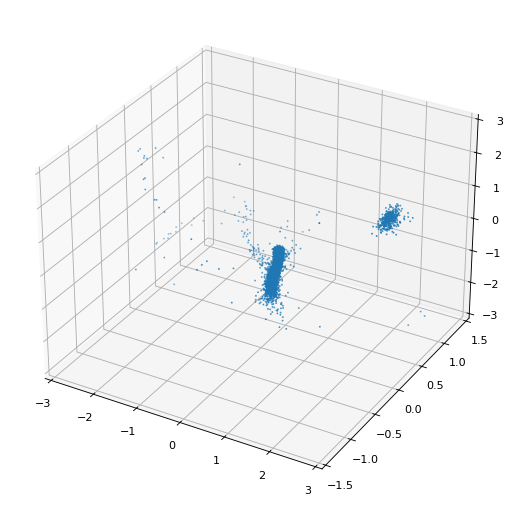

In [19]:

def inference(vfield_net, n_test=None):
    with torch.no_grad():
        if n_test is None:
            n_test = testset.data.shape[0]

        acc_rotaxis_traj = []
        acc_rotang_traj = []
        # print('infer model dtype',list(vfield_net.parameters())[0].dtype)
        # print('data dtype',torch.cat([zt, t[:, None]], dim=-1).dtype)
        rotmat_t = torch.tensor(Rotation.random(n_test).as_matrix()).to(device)
        m_rotaxis_t, m_rotang_t = rotmat_to_axis_angle(rotmat_t) 
        rotmat_t = rotmat_t.reshape(-1, 9)
        acc_rotaxis_t = torch.zeros_like(m_rotang_t)
        acc_rotang_t = torch.zeros_like(m_rotang_t)       
        for time_index in trange(1, n_steps+1):
            t = (time_index-1) * torch.ones(size=(n_test,1), device=device)/n_steps 
            t_index = t * n_steps + 1
            pred_rotaxis_1, pred_rotang_1 = net_pred(vfield_net, rotmat_t, t, acc_rotaxis_t, acc_rotang_t)
          
            # bayesian update
            alpha_rotaxis_i = BFN.sphere_alpha_wrt_index(t_index, N=n_steps, beta1=beta1_rot_axis, p=3)
            alpha_rotang_i = BFN.alpha_wrt_index(t_index, N=n_steps, beta1=beta1_rot_ang)

            m_rotang_t, acc_rotang_t = BFN.circular_var_bayesian_update(
                loc_prev=m_rotang_t, conc_prev=BFN.circular_denorm_conc(acc_rotang_t, beta1=beta1_rot_ang),
                alpha=alpha_rotang_i, pred_x=pred_rotang_1)
            acc_rotang_traj.append(acc_rotang_t.mean().detach().cpu().numpy())
            acc_rotang_t = BFN.circular_norm_logbeta(acc_rotang_t.log(), beta1=beta1_rot_ang)
            
            m_rotaxis_t, acc_rotaxis_t = BFN.sphere_var_bayesian_update(
                loc_prev=m_rotaxis_t, conc_prev=BFN.sphere_denorm_conc(acc_rotaxis_t, beta1=beta1_rot_axis),
                alpha_i=alpha_rotaxis_i, pred_x=pred_rotaxis_1)
            acc_rotaxis_traj.append(acc_rotaxis_t.mean().detach().cpu().numpy())
            acc_rotaxis_t = BFN.sphere_norm_log_conc(acc_rotaxis_t.log(), beta1=beta1_rot_axis)
            
            rotmat_t = rc.axis_angle_to_matrix(m_rotaxis_t * m_rotang_t, fast=True).reshape(-1, 9)
            

    return rotmat_t.reshape(-1, 3, 3), acc_rotaxis_traj, acc_rotang_traj

# inference on the full dataset for visualization
plt.style.use('default')
n_test = 10000
traj = torch.tensor(Rotation.random(n_test).as_matrix()).to(device).reshape(-1, 9)
traj,acc_rotaxis_traj, acc_rotang_traj = inference(vfield_net, n_test=n_test)

fig = plot_so3(traj)
plt.show()

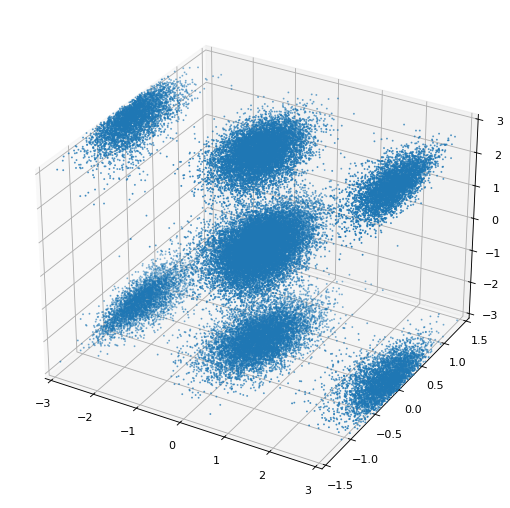

In [18]:
fig = plot_so3(data)